In [1]:
%matplotlib widget

# The potential of the electromagnetic induction method to monitor temperature changes in the near-surface

## Maria Carrizo, Dieter Werthmüller, and Evert Slob
Delft University of Technology, Faculty of Civil Engineering and Geosciences , Department of Applied Geophysics and Petrophysics, Delft, Netherlands (m.e.carrizomascarell@tudelft.nl)

In [18]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from empymod import filters
import pygimli as pg
import matplotlib.tri as tri
import sys
sys.path.insert(1, 'src')

# Load forward functions and function that performs global search in lookup table
from EM1D import EMf_2Lay_HVP, GlobalSearch_2Lay, EMf_2Lay_Opt_HVP, ErrorSpace_2Lay
from Plots import PlotModelData, PlotModel, PlotErrorSpace_2Lay
from utils import rmse

ImportError: cannot import name 'PlotErrorSpace_2Lay' from 'Plots' (/home/mariacarrizo/repos/EMI_Gw_Temp_1D/src/Plots.py)

## EM Induction 

For the models data is simulated for an EMI device with the following characteristics
  - Frequency: 9000 Hz
  - Geometries: Horizontal coplanar (H) with offsets [2 m, 4 m, 8 m], Vertical coplanar (V) with offsets [2 m, 4 m, 8 m], and Perpendicular (P) with offsets [2.1 m, 4.1 m, 8.1 m]
  - Data obtained: vector with the Quadrature (Q) and In-phase (IP) components of the measurements for the H, V and P coil orientations as $\mathbf{d} = [Q_{H2}, Q_{H4}, Q_{H8}, Q_{V2}, Q_{V4}, Q_{V8}, Q_{P2}, Q_{P4}, Q_{P8}, IP_{H2}, IP_{H4}, IP_{H8}, IP_{V2}, IP_{V4}, IP_{V8}, IP_{P2}, IP_{P4}, IP_{P8}]$

## Inversion feasibility for 2-layered EC models

Here, we evaluate the information content in the EMI measurements to determine 1D 2-layered and 3-layered EC models

Assuming 2-layered EC models the model parameters would be a model $m$ vector:

\begin{equation}
    \mathbf{m} = [\sigma_1, \sigma_2, h_1],
\end{equation}

where $\sigma_1$ is the EC of the first layer, $\sigma_2$ is the electrical conductivity of the second layer and
$h_1$ is the thickness of the first layer

We use the method discussed in [Carrizo et. al., 2023](https://doi.org/10.3997/2214-4609.202320049) to generate Lookup tables and perform a global search to estimate a 2-layered model.

The lookup table was generated using `1_LUTable2Lay.py` and stored in `Lookup_Tables/2Lay`. The global search will find the best data fit in the lookup table indicating the best fitting model.

In [3]:
# Settings for measurements simulations

# Define hankel filter
filt = filters.key_201_2012() 

# Define EMI instrument geometry
offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meters height from ground surface to center of coils
freq = 9000 # Frequency in Hz
# Lambda numbers
lambd = filt.base/offsets[:,np.newaxis] 

In [4]:
# Load lookup table and sampling ranges used
LU_2Lay = np.load('Lookup_Tables/2Lay/LUTable_2Lay.npy')
conds = np.load('Lookup_Tables/2Lay/conds.npy')
thicks = np.load('Lookup_Tables/2Lay/thicks.npy')
# number of samples
nsl = len(conds)

# DELETE
# Perform global search  
#model_est_2Lay = GlobalSearch_2Lay(LU_2Lay, data_base, conds, thicks, nsl)

In [5]:
# Generate a 2 layered model and simulate EMI measurements

sigma_1 = 10/1000 # S/m
sigma_2 = 350/1000 # S/m
h1 = 4.4 # m

model_2Lay_true =  ([sigma_1, sigma_2, h1])
data_2Lay_true = EMf_2Lay_HVP(lambd, sigma_1, sigma_2, h1, height, offsets, freq, filt)

In [6]:
# Perform inversion with global search and obtain an estimated best data-fitting model
model_2Lay_est = GlobalSearch_2Lay(LU_2Lay, data_2Lay_true, conds, thicks, nsl)

# Simulate data for the estimated model
data_2Lay_est = EMf_2Lay_HVP(lambd, 
                             sigma1 = model_2Lay_est[0],
                             sigma2 = model_2Lay_est[1],
                             h1 = model_2Lay_est[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:24:23 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


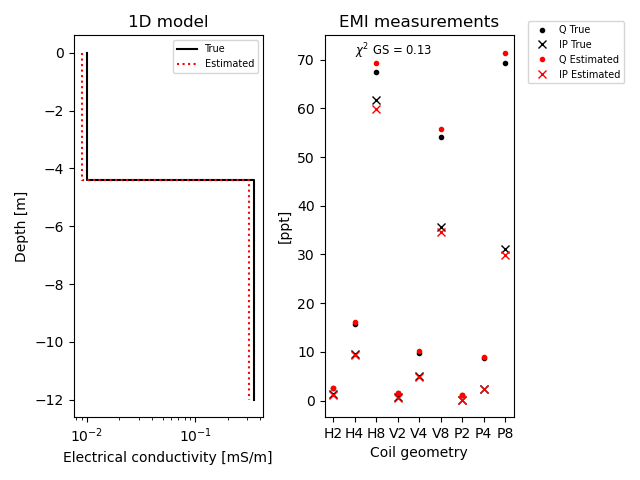

In [7]:
# The initial and estimated model can be plotted now

dmax = -12
sigma_2Lay_true_plot = np.hstack((model_2Lay_true[:2], model_2Lay_true[1]))
depths_2Lay_true_plot = np.array([0, -h1, dmax])

sigma_2Lay_est_plot = np.hstack((model_2Lay_est[:2], model_2Lay_est[1]))
depths_2Lay_est_plot = np.array([0, -model_2Lay_est[2], dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_2Lay_true_plot, depths_2Lay_true_plot, data_2Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_2Lay_est_plot, depths_2Lay_true_plot, data_2Lay_est, model_name='Estimated', 
              data_name='Estimated', ax=ax, model_style=':r', data_style='r')
ax[1].text(1, 71, '$\chi^2$ GS = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est)), fontsize='small')

plt.savefig('figures/2Lay_Model.eps', format='eps')

### Noise analysis

The 2-layered EC model is accurately estimated, but how can noise affect the estimations?
We can evaluate the error space:

In [8]:
def NoiseAnalysis_2Lay(data_true, noise=0.1, test_it=100):
    
    models = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models.append(GlobalSearch_2Lay(LU_2Lay, data_noise, conds, thicks, nsl))
    return models
        
models_noise = NoiseAnalysis_2Lay(data_2Lay_true)

17/04/24 - 09:38:06 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


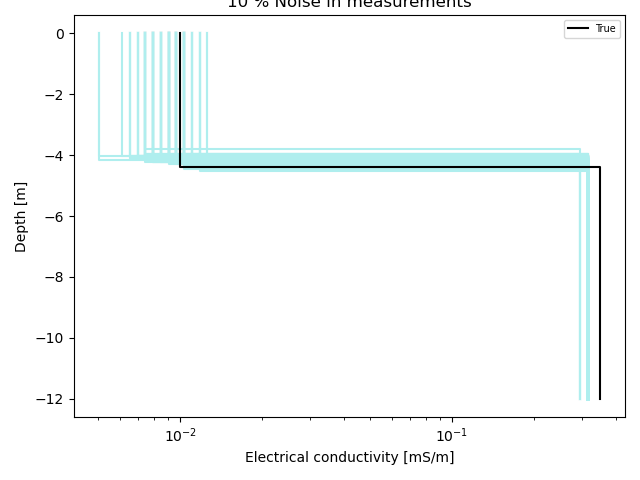

In [10]:
# Plot several random estimated models obtained with noisy data
fig, ax = plt.subplots()

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_2Lay_plot = np.hstack((mod[:2], mod[1]))
    depths_2Lay_plot = np.array([0, -mod[2], dmax])
    PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_2Lay_true_plot, depths_2Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/2Lay_Noise.eps', format='eps')

### Gradient descent inversion

It's also possible to analise the possibility of obtaining the estimated model through a gradient descent inversion by minimising the misfit of the following equation iteratively, given an initial model.

\begin{equation}
   \Phi = \lVert \boldsymbol{W}_d (\mathcal{F}(\boldsymbol{m}) - \boldsymbol{d}) \rVert_2^2 + \alpha \rVert \boldsymbol{W}_m (\boldsymbol{m} - \boldsymbol{m}_0) \lVert_2^2 ,
\end{equation}

In [11]:
# Initialize the forward modelling class 
EMf = EMf_2Lay_Opt_HVP(lambd, height, offsets, freq, filt)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_2Lay_true[0]) * error

# Start inversion
model_2Lay_est_gd = invEM.run(data_2Lay_true, relativeError, verbose=False)

# Data from estimated model
data_2Lay_est_gd = EMf_2Lay_HVP(lambd, 
                             sigma1 = model_2Lay_est_gd[0],
                             sigma2 = model_2Lay_est_gd[1],
                             h1 = model_2Lay_est_gd[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:38:19 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000


17/04/24 - 09:38:25 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


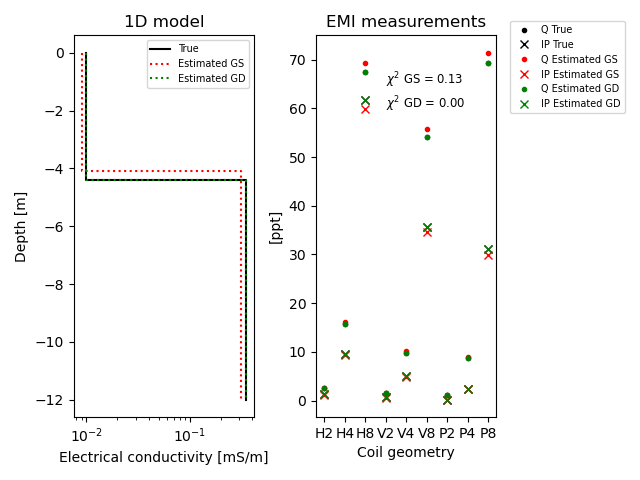

In [12]:
sigma_2Lay_est_gd_plot = np.hstack((model_2Lay_est_gd[:2], model_2Lay_est_gd[1]))
depths_2Lay_est_gd_plot = np.array([0, -model_2Lay_est_gd[2], dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_2Lay_true_plot, depths_2Lay_true_plot, data_2Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_2Lay_est_plot, depths_2Lay_est_plot, data_2Lay_est, model_name='Estimated GS', 
              data_name='Estimated GS', ax=ax, model_style=':r', data_style='r')
PlotModelData(sigma_2Lay_est_gd_plot, depths_2Lay_est_gd_plot, data_2Lay_est_gd, model_name='Estimated GD', 
              data_name='Estimated GD', ax=ax, model_style=':g', data_style='g')

ax[1].text(3, 65, '$\chi^2$ GS = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est)), fontsize='small')
ax[1].text(3, 60, '$\chi^2$ GD = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est_gd)), fontsize='small')

plt.savefig('figures/2Lay_Model_GS_GD.eps', format='eps')

### Noise analysis using gradient descent method

We can also estimate using gradient descent method the estimation of 1D 2-layered models using noisy measurements with 10% noise  

In [13]:
def NoiseAnalysis_2Lay_GD(data_true, noise=0.1, test_it=100):
    
    models = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        
        # Initialize the forward modelling class 
        EMf = EMf_2Lay_Opt_HVP(lambd, height, offsets, freq, filt)

        # Define inversion framework from pygimli
        invEM = pg.Inversion()
        invEM.setForwardOperator(EMf) # set forward operator

        # Relative error array
        error = 1e-3 # relative error
        relativeError = np.ones_like(data_true[0]) * error

        # Start inversion
        models.append(invEM.run(data_noise, relativeError, verbose=False))

    return models
        
models_noise = NoiseAnalysis_2Lay_GD(data_2Lay_true)

17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:34 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:35 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 - 09:38:35 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
17/04/24 -

17/04/24 - 09:42:25 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


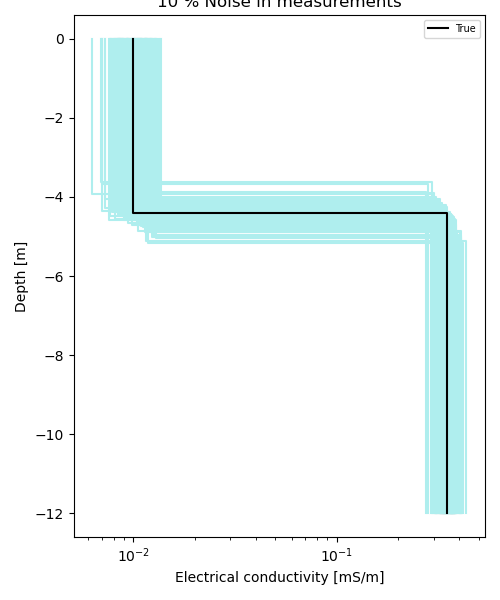

In [17]:
fig, ax = plt.subplots(figsize=(5,6))

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_2Lay_plot = np.hstack((mod[:2], mod[1]))
    depths_2Lay_plot = np.array([0, -mod[2], dmax])
    PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_2Lay_true_plot, depths_2Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/2Lay_Noise_GD.eps', format='eps')

### Error space

Using the data simulated in the Lookup Table we can analyse cross sections of the error space and evaluate if the estimated model is a true global minima 

In [15]:
# search the error space and output models with error < 0.2
err, models_err = ErrorSpace_2Lay(LU_2Lay, data_2Lay_est, 0.08, conds, thicks, nsl)

In [16]:
# Plot the resulting error space cross section
PlotErrorSpace_2Lay(model_2Lay_true, model_2Lay_est, err, models_err)
plt.savefig('figures/2Lay_ErrorSpace.eps', format='eps')

NameError: name 'PlotErrorSpace_2Lay' is not defined